In [1]:
using CUDA, LinearAlgebra, BenchmarkTools, MatrixEquations, Distributions


rows = 8192
cols = 64

# Function to generate Maxwellian distributed values
function generate_maxwell_gpu(a, n)
    dist = Normal(0, a)
    random_normals = CUDA.randn(Float64, (1, n)) 
    return sqrt.(sum(random_normals.^2, dims=1))
end

function generate_maxwell_cpu(a, n)
    dist = Normal(0, a)
    random_normals = randn(Float64, (1, n)) 
    return sqrt.(sum(random_normals.^2, dims=1))
end

# Create Maxwellian distributed matrix
function maxwell_matrix_cpu(a, rows, cols)
    matrix = zeros(Float64, cols, rows)
    for i in 1:rows
        matrix[:, i] .= generate_maxwell_cpu(a, cols)
    end
    return matrix
end

function maxwell_matrix_gpu(a, rows, cols)
    matrix = CUDA.zeros(Float64, cols, rows)
    for i in 1:rows
        matrix[:, i] .= generate_maxwell_gpu(a, cols)
    end
    return matrix
end


#------------------------------------------------------------
M_cpu = maxwell_matrix_cpu(1.0, rows, cols)
M_gpu = maxwell_matrix_gpu(1.0, rows, cols)


SVD_Result_cpu = svd(M_cpu)
SVD_Result_gpu = svd(M_gpu)

U_cpu = SVD_Result_cpu.U
S_cpu = SVD_Result_cpu.S
Vt_cpu = SVD_Result_cpu.Vt
U_gpu = SVD_Result_gpu.U
S_gpu = SVD_Result_gpu.S
Vt_gpu = SVD_Result_gpu.Vt

relative_S_cpu = S_cpu / maximum(S_cpu)
relative_S_gpu = S_gpu / maximum(S_gpu)

# Define a threshold
gamma = 0.5

kcpu = sum(relative_S_cpu .> gamma)
kgpu = sum(relative_S_gpu .> gamma)

Uk_cpu = U_cpu[:, 1:kcpu]
Sk_cpu = Diagonal(S_cpu[1:kcpu]) 
Vtk_cpu = Vt_cpu[1:kcpu, :]
Uk_gpu = U_gpu[:, 1:kgpu]
Sk_gpu = Diagonal(S_gpu[1:kgpu]) 
Vtk_gpu = Vt_gpu[1:kgpu, :]


A_truncated_cpu = Uk_cpu * Sk_cpu * Vtk_cpu
A_truncated_gpu = Uk_gpu * Sk_gpu * Vtk_gpu

A_truncated_cpu = Array(A_truncated_cpu)
A_truncated_gpu = Array(A_truncated_gpu)

println("Size of the truncated matrix A_truncated is $(size(A_truncated_cpu))")
println("The number of significant singular values k is $kcpu")
println("Size of the truncated matrix A_truncated is $(size(A_truncated_gpu))")
println("The number of significant singular values k is $kgpu")

LoadError: DimensionMismatch: cannot broadcast array to have fewer non-singleton dimensions

In [2]:
using CUDA
using LinearAlgebra
using BenchmarkTools
using MatrixEquations
using Distributions
using Plots


w= 2π

p(x) = 1 + 7/8 * sin(w * x)
u(x) = 3/4
T(x) = 1/2 + 2/5 * sin(w * x)

function f(x, v)
    term1 = exp(-(v - u(x))^2 / (2 * T(x)))
    term2 = exp(-(v + u(x))^2 / (2 * T(x)))

    
    return p(x) / (2 * sqrt(2π * T(x))) * (term1 + term2)
end

x_range = -1/2:0.01:1/2
v_range = -10:0.1:10

x_grid = repeat(x_range, length(v_range))
v_grid = repeat(v_range, inner=length(x_range))

# Compute f on the grid
f_values = [f(x, v) for (x, v) in zip(x_grid, v_grid)]

# Reshape the computed values to match the grid dimensions
f_matrix = reshape(f_values, length(v_range), length(x_range))
#---------------------------------------------

SVD_Result_cpu = svd(f_matrix)
SVD_Result_gpu = svd(CUDA.cu(f_matrix))

U_cpu = SVD_Result_cpu.U
S_cpu = SVD_Result_cpu.S
Vt_cpu = SVD_Result_cpu.Vt
U_gpu = SVD_Result_gpu.U
S_gpu = SVD_Result_gpu.S
Vt_gpu = SVD_Result_gpu.Vt

relative_S_cpu = S_cpu / maximum(S_cpu)
relative_S_gpu = S_gpu / maximum(S_gpu)

# Define a threshold
gamma = 2e-3

kcpu = sum(relative_S_cpu .> gamma)
kgpu = sum(relative_S_gpu .> gamma)



println("Size of the truncated matrix A_truncated is $(size(kcpu))")
println("The number of significant singular values k is $kcpu")
println("Size of the truncated matrix A_truncated is $(size(kgpu))")
println("The number of significant singular values k is $kgpu")

kcpu

Size of the truncated matrix A_truncated is ()
The number of significant singular values k is 10
Size of the truncated matrix A_truncated is ()
The number of significant singular values k is 10


10

(i, a) = (1, 0.5)
(i, a) = (2, 0.25)
(i, a) = (3, 0.125)
(i, a) = (4, 0.0625)
(i, a) = (5, 0.03125)
(i, a) = (6, 0.015625)
(i, a) = (7, 0.0078125)
(i, a) = (8, 0.00390625)
(i, a) = (9, 0.001953125)


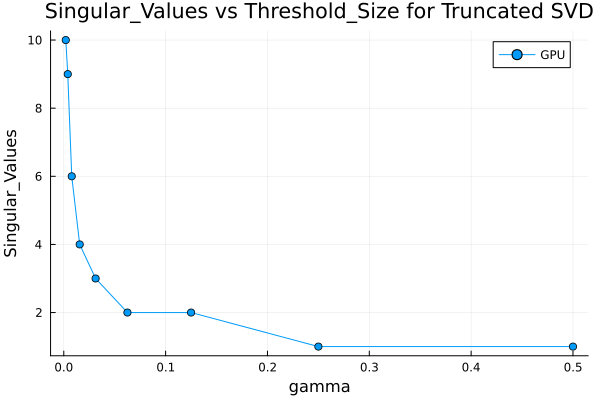

In [3]:
using CUDA
using LinearAlgebra
using Plots

w= 2π

p(x) = 1 + 7/8 * sin(w * x)
u(x) = 3/4
T(x) = 1/2 + 2/5 * sin(w * x)

function f(x, v)
    term1 = exp(-(v - u(x))^2 / (2 * T(x)))
    term2 = exp(-(v + u(x))^2 / (2 * T(x)))

    
    return p(x) / (2 * sqrt(2π * T(x))) * (term1 + term2)
end

x_range = -1/2:0.01:1/2
v_range = -10:0.1:10

x_grid = repeat(x_range, length(v_range))
v_grid = repeat(v_range, inner=length(x_range))


f_matrix_gpu = reshape([f(x, v) for (x, v) in zip(x_grid, v_grid)], length(v_range), length(x_range))
#---------------------------------------------


function TestGPU(gamma, matrix)
    gpu_matrix = CUDA.cu(matrix)
    kappas = zeros(Int, length(gamma))

    for (i, a) in enumerate(gamma)
        @show (i, a)
        
            
        SVD_Result_gpu = CUDA.svd(gpu_matrix)
            
        S_gpu = SVD_Result_gpu.S
            
        relative_S_gpu = S_gpu / maximum(S_gpu)
            
        gamma_gpu = CUDA.cu(a)

        kappas[i] = CUDA.sum(relative_S_gpu .> gamma_gpu)
        
    end
    return kappas
end

# Define thresholds
gamma = [2^-1, 2^-2, 2^-3, 2^-4, 2^-5, 2^-6, 2^-7, 2^-8, 2^-9]

kappasGPU = TestGPU(gamma, f_matrix_gpu)

p1 = plot(gamma, kappasGPU, title="Singular_Values vs Threshold_Size for Truncated SVD", xlabel="gamma", ylabel="Singular_Values", label="GPU", marker=:circle, legend=:topright)
#plot!(p1, gamma, kappasGPU, label="Significant Value", marker=:circle)

(i, a) = (1, 256)
(i, a) = (2, 512)
(i, a) = (3, 1024)
(i, a) = (4, 2048)
(i, a) = (5, 4096)
(i, a) = (1, 256)
(i, a) = (2, 512)
(i, a) = (3, 1024)
(i, a) = (4, 2048)
(i, a) = (5, 4096)


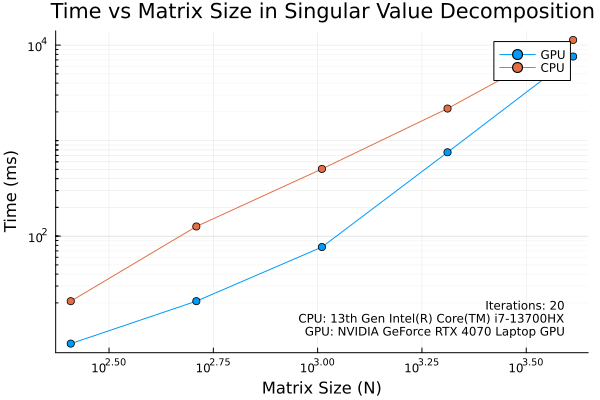

In [4]:
using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

# SVD

function TestGPU(N, C)
    
    Time = zeros(Float32, length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = CUDA.randn(Float32, a, a)         
        data = @benchmark CUDA.@sync svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds

    end

    return Time

end

function TestCPU(N, C)
    
    Time = zeros(Float32, length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = randn(Float32, a, a)        
        data = @benchmark svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
    end

    return Time

end


N = 2 .^ (8:12)
C = 20
timesGPU = TestGPU(N, C)
timesCPU = TestCPU(N, C)

#---------------------------------------------------------------------------------------#
x_pos = maximum(N) * 0.95  # Adjust to position the text within the plot area
y_pos = minimum(timesGPU) * 1.05  # Adjust based on the minimum time value


cpu_info = Sys.cpu_info()[1].model # display device name
gpu_info = CUDA.name(CUDA.device()) # display device name
#---------------------------------------------------------------------------------------#

p1 = plot(N, timesGPU, title="Time vs Matrix Size in Singular Value Decomposition", xlabel="Matrix Size (N)", xaxis=:log, ylabel="Time (ms)", yaxis=:log, label="GPU", marker=:circle, legend=:topright, grid=:on, minorgrid=true)
plot!(p1, N, timesCPU, label="CPU", marker=:circle)
annotate!(p1, [(x_pos, y_pos, text("Iterations: $C\nCPU: $cpu_info\nGPU: $gpu_info", 8, :right, :bottom))])

In [1]:
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using Printf
using Plots
using MatrixEquations

function Syl_EK(Vx_n, Vy_n, S_n, A, B, tol)
    
    @printf " first line \n"
    normb = norm(S_n)
    FA = factorize(A)
    FB = factorize(B)
    Vx_nn = Vx_n
    Vy_nn = Vy_n
    S_nn =  S_n
    @printf " second line \n"
    DxVxn = Vx_n
    DyVyn = Vy_n
    Dxinv = Vx_n
    Dyinv = Vy_n
    acc = false
    s = 1
    
    @printf "EK starts \n"
    while !acc
        if s == 1
            @printf "Case1 \n"
            @show size(A)
            @show size(DxVxn)
            DxVxn = A * DxVxn
            DyVyn = B * DyVyn
            @printf "Case1.5 \n"
            Dxinv = FA \ Dxinv
            Dyinv = FB \ Dyinv
            Vx_aug = hcat(Vx_n, DxVxn, Dxinv)
            Vy_aug = hcat(Vy_n, DyVyn, Dyinv)
            Vx_nn, _ = qr(Vx_aug, Val(false))
            Vy_nn, _ = qr(Vy_aug, Val(false))
        else
            @printf "Case2 \n"
            DxVxn = A * DxVxn
            DyVyn = B * DyVyn
            Dxinv = FA \ Dxinv
            Dyinv = FB \ Dyinv
            Vx_aug = hcat(Vx_nn, DxVxn, Dxinv)
            Vy_aug = hcat(Vy_nn, DyVyn, Dyinv)
            Vx_nn, _ = qr(Vx_aug, Val(false))
            Vy_nn, _ = qr(Vy_aug, Val(false))
        end
        @printf "Case3 \n"
        AV = A * Vx_nn
        A11 = Vx_nn' * AV
        BV = B * Vy_nn
        B11 = Vy_nn' * BV

        _, R11 = qr(hcat(Vx_nn, AV), Val(false))
        _, R22 = qr(hcat(Vy_nn, BV), Val(false))

        RHS = (Vx_nn' * Vx_n) * S_n * (Vy_n' * Vy_nn)
        S1 = sylvc(A11, B11, RHS) 

        @printf "sylvster start"
        sto = R11 * [-RHS S1; S1 zeros(size(S1, 1), size(S1, 2))] * R22'
        norm1 = norm(sto)
        if abs(norm1) / normb < tol
            @printf "if Loop \n"
            t1, S1n, t2 = svd(S1)
            r = findmax(S1n .> 1e-8)[2]
            @show typeof(r)
            @printf "if Loop2 \n"
            Vx_nn = Vx_nn * t1[:, 1:r]
            @printf "if Loop3 \n"
            Vy_nn = Vy_nn * t2[:, 1:r]
            @printf "if Loop4 \n"
            S_n = Diagonal(S1n[1:r]) 
            acc = true
        end
        @printf "if Loop ends \n"
        if !acc
            s += 1
        else
            break
        end
    end

    return Vx_nn, Vy_nn, S_nn
end



#----------------------------------------------------------------------------------
# Simulation parameters
L = 1                  # Length of interval
Ny = 101               # Number of grid points in the Y dimension
Nx = 101               # Number of grid points in the X dimension
rel_eps = 1e-3         # Relative tolerance for singular value decomposition
dtn = 1e-2             # Initial time step size
Tf = 1                 # Total simulation time

# Generate linearly spaced vectors for x, y, and t values
xvals = range(0, stop=L, length=Nx)
yvals = range(0, stop=L, length=Ny)
tvals = range(0, stop=Tf, step=dtn)

dx = xvals[2] - xvals[1]
dy = yvals[2] - yvals[1]
dtn = tvals[2] - tvals[1] # Ensure tvals are generated before this line

# Generate second-order differential matrices for x, y using finite differences
Dxx = spdiagm(0 => -2*ones(Nx-2), 1 => ones(Nx-2), -1 => ones(Nx-2)) / dx^2
Dyy = spdiagm(0 => -2*ones(Ny-2), 1 => ones(Ny-2), -1 => ones(Ny-2)) / dy^2
@show size(Dxx)
@show size(Dyy)

# Initial condition setup using rank-2 Gaussian distributions
x_range = 0:dx:L
y_range = 0:dy:L

function f(x, y)
    return 0.5 * exp.(-400 * (x - 0.3)^2 - 400 * (y - 0.35)^2) +
           0.8 * exp.(-400 * (x - 0.65)^2 - 400 * (y - 0.5)^2)
end

# Compute initial condition
f_matrix = [f(x, y) for x in x_range, y in y_range]

f_matrix = f_matrix[1:end-1, 1:end-1]
@show size(f_matrix)

# Perform SVD on initial condition matrix (corrected)
SVD_Result = svd(f_matrix)
Vx_n = SVD_Result.U
S_n = SVD_Result.S
Vy_n = SVD_Result.V
Vx_n = Vx_n[:,1:2]
Vy_n = Vy_n[:,1:2]
S_n = Diagonal(S_n[1:2])  # Correct handling of singular values
@printf "before sparse A&B\n"
# Define matrices for implicit scheme
d1 = 1/2 # Coefficient for X dimension in diffusion equation
d2 = 1/2 # Coefficient for Y dimension in diffusion equation


A = I(Nx-1) * (1/3) - dtn * d1^2 * Dxx # Implicit matrix for X dimension
B = I(Ny-1) * (1/3) - dtn * d2^2 * Dyy # Implicit matrix for Y dimension

tol = 1e-2 # Tolerance for Sylvester solver
@printf "before Syl_EK\n"
# Placeholder for solving the Sylvester equation and benchmarking it
# Assuming `Syl_EK` is a user-defined function or to be replaced with a correct library call
@btime Vx_nn, Vy_nn, S_nn = Syl_EK(Vx_n, Vy_n, S_n, A, B, tol)  # Correct calling syntax


size(Dxx) = (100, 100)
size(Dyy) = (100, 100)
size(f_matrix) = (100, 100)
before sparse A&B
before Syl_EK
 first line 
 second line 
EK starts 
Case1 
size(A) = (100, 100)
size(DxVxn) = (100, 2)
Case1.5 
Case3 
sylvster startif Loop 
typeof(r) = Int64
if Loop2 
if Loop3 
if Loop4 
if Loop ends 
 first line 
 second line 
EK starts 
Case1 
size(A) = (100, 100)
size(DxVxn) = (100, 2)
Case1.5 
Case3 
sylvster startif Loop 
typeof(r) = Int64
if Loop2 
if Loop3 
if Loop4 
if Loop ends 
 first line 
 second line 
EK starts 
Case1 
size(A) = (100, 100)
size(DxVxn) = (100, 2)
Case1.5 
Case3 
sylvster startif Loop 
typeof(r) = Int64
if Loop2 
if Loop3 
if Loop4 
if Loop ends 
 first line 
 second line 
EK starts 
Case1 
size(A) = (100, 100)
size(DxVxn) = (100, 2)
Case1.5 
Case3 
sylvster startif Loop 
typeof(r) = Int64
if Loop2 
if Loop3 
if Loop4 
if Loop ends 
 first line 
 second line 
EK starts 
Case1 
size(A) = (100, 100)
size(DxVxn) = (100, 2)
Case1.5 
Case3 
sylvster startif Loop 
typeof

([0.0003340447010946601; 0.0006772573973478635; … ; -1.669139677971128e-5; -0.000543734159878249;;], [9.974751087604705e-5; 0.0002022473645274525; … ; -1.1632707062930774e-6; -3.958977235859066e-5;;], [5.01345481608374 0.0; 0.0 3.1329680940413653])